In [ ]:
# !pip install evaluate
# !pip install onnx
# !pip install onnxruntime
# !pip install datasets==3.3.1
# # !pip install optimum
# !pip install openvino
# !pip install openvino-dev
# !pip install optimum-executorch@git+https://github.com/huggingface/optimum-executorch.git
# !pip install --upgrade --upgrade-strategy eager "optimum[openvino]"

In [1]:
import os # для взаимодействия с системой
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import random as random # для работы со случайностью
import json # для сохранения и загрузки объектов
from tqdm.auto import tqdm # для отслеживания прогресса

from datasets import Dataset, load_dataset, load_from_disk # для работы с HuggingFace датасетами

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate # для подсчёта метрик


# PyTorch Runtime
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# ExecuTorch
from optimum.executorch import ExecuTorchModelForSeq2SeqLM

# ONNX
from optimum.onnxruntime import ORTModelForSeq2SeqLM

# OpenVINO (ломает ExecuTorch, поэтому импорт будет в соответствующих блоках)
# from optimum.intel.openvino import OVModelForSeq2SeqLM

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATA_DIR = "/content/drive/MyDrive/tmp/data/"
RESULTS_DIR = "/content/drive/MyDrive/tmp/results/"
MODELS_DIR = "/content/drive/MyDrive/tmp/models/"
MODEL_NAME = "t5_pruned_0.2_finetuned"
DATASET_NAME_HF = "aiana94/polynews-parallel" # название датасета на huggingface
DATASET_NAME_LOC = "polynews-parallel" # название, под которым датасет будет сохранён локально (+ с предобработкой)

MAX_SEQUENCE_LEN = 256

RANDOM_STATE = 42
TEST_SIZE = 0.2
TEST_MAX_SAMPLES = 5000

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
print(f"Status: \n\
      DATA_DIR: {DATA_DIR}\n\
      RESULTS_DIR: {RESULTS_DIR}\n\
      MODELS_DIR: {MODELS_DIR}\n\
      MODEL_NAME: {MODEL_NAME}\n\
      DATASET_NAME_HF: {DATASET_NAME_HF}\n\
      DATASET_NAME_LOC: {DATASET_NAME_LOC}\n\
      MAX_SEQUENCE_LEN: {MAX_SEQUENCE_LEN}\n\
      RANDOM_STATE: {RANDOM_STATE}\n\
      TEST_SIZE: {TEST_SIZE}\n\
      TEST_MAX_SAMPLES: {TEST_MAX_SAMPLES}\n\
      DEVICE: {DEVICE}\n\
      ")


Status: 
      DATA_DIR: /content/drive/MyDrive/tmp/data/
      RESULTS_DIR: /content/drive/MyDrive/tmp/results/
      MODELS_DIR: /content/drive/MyDrive/tmp/models/
      MODEL_NAME: t5_pruned_0.2_finetuned
      DATASET_NAME_HF: aiana94/polynews-parallel
      DATASET_NAME_LOC: polynews-parallel
      MAX_SEQUENCE_LEN: 256
      RANDOM_STATE: 42
      TEST_SIZE: 0.2
      TEST_MAX_SAMPLES: 5000
      DEVICE: cpu
      


# Dataset

In [5]:
tokenizer = T5Tokenizer.from_pretrained(MODELS_DIR + MODEL_NAME)

In [6]:
if not os.path.exists(DATA_DIR + DATASET_NAME_LOC):
    print("Скачиваю и сохраняю датасет...")
    dataset = load_dataset(DATASET_NAME_HF, name="eng_Latn-rus_Cyrl") # скачивание датасета, name — название subset_а с HuggingFace
    dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC) # локальное сохранение датасета (в формате arrow)
else:
    print(f"Датасет по пути {DATA_DIR + DATASET_NAME_LOC} уже был сохранён ранее, используем его!")
    dataset = load_from_disk(DATA_DIR + DATASET_NAME_LOC)

Датасет по пути /content/drive/MyDrive/tmp/data/polynews-parallel уже был сохранён ранее, используем его!


In [7]:
def preprocess_function(data: Dataset, random_state=RANDOM_STATE):
    random.seed(random_state) # Set the random number generator to a fixed sequence.
    samples_count = len(dataset["train"]) # общее число сэмплов в датасете

    reflected_idx = set(random.sample(range(0, samples_count), int(samples_count/2))) # индексы отражаемых сэмплов (set — для сортировки и удобного вычитания)
    regular_idx = set(range(0, samples_count)) - reflected_idx

    data["new_src"] = ["translate to ru: " + sample if idx in regular_idx else "translate to en: " + data["tgt"][idx] for idx, sample in enumerate(data["src"])]
    data["new_tgt"] = [sample if idx in regular_idx else data["src"][idx] for idx, sample in enumerate(data["tgt"])]
    model_inputs = tokenizer(data["new_src"], text_target=data["new_tgt"], max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True)
    return model_inputs


if not os.path.exists(DATA_DIR + DATASET_NAME_LOC + "_t5_processed"):
    print("Обрабатываю датасет и сохраняю...")
    dataset = dataset.map(preprocess_function, batched=True)
    dataset = dataset.remove_columns(["provenance", "src", "tgt"]) # удаление ненужной колонки
    dataset = dataset.rename_column("new_src", "src") # переименовываем колонку
    dataset = dataset.rename_column("new_tgt", "tgt") # переименовываем колонку
    dataset = dataset["train"].train_test_split(test_size=TEST_SIZE, shuffle=True, seed=RANDOM_STATE) # разбиение датасета на тестовую и обучающую выборки

    dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed") # локальное сохранение датасета (в формате arrow)
else:
    print(f"Датасет по пути {DATA_DIR + DATASET_NAME_LOC + '_t5_processed'} уже был сохранён ранее, используем его!")
    dataset = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed")


dataset["test"] = dataset["test"].select(range(TEST_MAX_SAMPLES))

Датасет по пути /content/drive/MyDrive/tmp/data/polynews-parallel_t5_processed уже был сохранён ранее, используем его!


# Runtime

In [8]:
tokens_count, latency, translations = {}, {}, {}

## ExecuTorch

Почему-то если использовать её не первой, то загрузить её не получиться...

In [9]:
model_exet = ExecuTorchModelForSeq2SeqLM.from_pretrained(MODELS_DIR + MODEL_NAME, export=True, recipe="xnnpack", attn_implementation="custom_sdpa") # export — для моделей трансформеров с версии optimum>=2.0, from_transformers — для optimum<2.0
# модель нельзя сохранить, так как эта фича пока не имплементирована...

/usr/local/lib/python3.11/dist-packages/executorch/exir/emit/_emitter.py:1592: UserWarning: Mutation on a buffer in the model is detected. ExecuTorch assumes buffers that are mutated in the graph have a meaningless initial state, only the shape and dtype will be serialized, unless a pass which sets meta["et_init_buffer"] to True such as InitializedMutableBufferPass is run.
  warnings.warn(
Too many ExecuTorch model files were found in /tmp/tmpudzkx779/encoder.pte ,/tmp/tmpudzkx779/decoder.pte. specify which one to load by using the `file_name` and/or the `subfolder` arguments. Loading the file encoder.pte in the subfolder /tmp/tmpudzkx779.
[program.cpp:135] InternalConsistency verification requested but not available
Too many ExecuTorch model files were found in /tmp/tmpudzkx779/encoder.pte ,/tmp/tmpudzkx779/decoder.pte. specify which one to load by using the `file_name` and/or the `subfolder` arguments. Loading the file decoder.pte in the subfolder /tmp/tmpudzkx779.
[program.cpp:135] 

In [10]:
def translate_exet(model, tokenizer, texts) -> tuple:
    tokens_count = [] # список под количество токенов в тексте
    latency = [] # список под величину задержки между запуском модели и выводом ответа
    translations = [] # список под переводы

    if isinstance(texts, str): # если пришёл объект типа строки
        texts = [texts] # делаем из объекта список с одним элементом
    elif isinstance(texts, Dataset) or isinstance(texts, dict): # если пришёл объект типа Dataset или словарь (полученный с помощью среза объекта Dataset)
        texts = texts["src"] # берём из него только текста, что нужно переводить

    for text in tqdm(texts):
        time_start = time.time() # замеряем время начала работы  с моделью
        generated_text = model.text_generation(
            tokenizer=tokenizer,
            prompt=text,
        )
        latency.append(time.time()  - time_start)

        tokens_encoded = tokenizer(text, max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
        tokens_count.append(tokens_encoded["input_ids"].shape[1]) # запоминаем количество токенов
        translations.append(generated_text) # декодирование последовательности токенов, skip_special_tokens — выводить ли специальные токены
    return tokens_count, latency, translations

In [ ]:
# затраченное время: 2 часа 28 минут
tokens_count["ExecuTorch"], latency["ExecuTorch"], translations["ExecuTorch"] = translate_exet(model_exet, tokenizer, dataset["test"])

  0%|          | 0/5000 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
PyTorchObserver {"prompt_tokens": 36, "generated_tokens": 29, "model_load_start_ms": 0, "model_load_end_ms": 0, "inference_start_ms": 1747876165207, "token_encode_end_ms": 1747876165207, "model_execution_start_ms": 1747876166727, "model_execution_end_ms": 1747876166777, "inference_end_ms": 1747876166777, "prompt_eval_end_ms": 1747876165256, "first_token_ms": 1747876165306, "aggregate_sampling_time_ms": 1562, "SCALING_FACTOR_UNITS_PER_SECOND": 1000}
	Prompt Tokens: 36 Generated Tokens: 29
	Model Load Time:		0.000000 (seconds)
	Total inference time:		1.570000 (seconds)		 Rate: 	18.471338 (tokens/second)
		Prompt evaluation:	0.049000 (seconds)		 Rate: 	734.693878 (tokens/second)
		Generated 29 tokens:	1.521000 (seconds)		 Rate: 	19.066404 (tokens/second)
	Time to first generated token:	0.099000 (seconds)
	Sampling time over 65 tokens:	1.562000 (seconds)

⚠️ DISCLAIMER: Python-based perf measurements are approximate and ma

## PyTorch

In [12]:
if not os.path.exists(MODELS_DIR + MODEL_NAME):
    print("Скачиваю и сохраняю модель...")
    model = T5ForConditionalGeneration.from_pretrained(MODELS_DIR + MODEL_NAME)
    tokenizer = T5Tokenizer.from_pretrained(MODELS_DIR + MODEL_NAME)

    model.save_pretrained(MODELS_DIR + MODEL_NAME, from_pt=True) # сохранение модели
    tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
else:
    print(f"Модель по пути {MODELS_DIR + MODEL_NAME} уже была сохранена ранее, используем её!")
    model = T5ForConditionalGeneration.from_pretrained(MODELS_DIR + MODEL_NAME)
    tokenizer = T5Tokenizer.from_pretrained(MODELS_DIR + MODEL_NAME)

Модель по пути /content/drive/MyDrive/tmp/models/t5_pruned_0.2_finetuned уже была сохранена ранее, используем её!


In [13]:
@torch.inference_mode()
def translate_pytorch(model, tokenizer, texts) -> tuple:
    tokens_count = [] # список под количество токенов в тексте
    latency = [] # список под величину задержки между запуском модели и выводом ответа
    translations = [] # список под переводы

    if isinstance(texts, str): # если пришёл объект типа строки
        texts = [texts] # делаем из объекта список с одним элементом
    elif isinstance(texts, Dataset) or isinstance(texts, dict): # если пришёл объект типа Dataset или словарь (полученный с помощью среза объекта Dataset)
        texts = texts["src"] # берём из него только текста, что нужно переводить

    model.eval() # перевод модели в режим оценивания (dropout перестаёт работать, а BatchNorm собирать статистику)

    model = torch.compile(model) # компилируем модель для оптимизации скорости работы

    with torch.no_grad(): # отключаем подсчёт градиентов
        for text in tqdm(texts):
            time_start = time.time() # замеряем время начала работы  с моделью
            tokens_encoded = tokenizer(text, max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
            tokens_generated = model.generate(**tokens_encoded) # генерируем новую последовательность токенов (переводим текст)

            latency.append(time.time()  - time_start)
            tokens_count.append(tokens_encoded["input_ids"].shape[1]) # запоминаем количество токенов
            translations.append(tokenizer.decode(tokens_generated[0], skip_special_tokens=True)) # декодирование последовательности токенов, skip_special_tokens — выводить ли специальные токены
    return tokens_count, latency, translations

In [ ]:
# затраченное время: 2 часа 19 минут
tokens_count["PyTorch"], latency["PyTorch"], translations["PyTorch"] = translate_pytorch(model, tokenizer, dataset["test"])

  0%|          | 0/5000 [00:00<?, ?it/s]

## ONNX (optimum)

In [15]:
model_onnx = ORTModelForSeq2SeqLM.from_pretrained(MODELS_DIR + MODEL_NAME, export=True) # export — для моделей трансформеров с версии optimum>=2.0, from_transformers — для optimum<2.0

if not os.path.exists(MODELS_DIR + "t5_ONNX"):
    model_onnx.save_pretrained(MODELS_DIR + "t5_ONNX")
    tokenizer.save_pretrained(MODELS_DIR + "t5_ONNX")

model_onnx

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/modeling_t5.py:1318: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sequence_length != 1:
/usr/local/lib/python3.11/dist-packages/transformers/cache_utils.py:457: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trac

In [16]:
def translate_onnx(model, tokenizer, texts) -> tuple:
    tokens_count = [] # список под количество токенов в тексте
    latency = [] # список под величину задержки между запуском модели и выводом ответа
    translations = [] # список под переводы

    if isinstance(texts, str): # если пришёл объект типа строки
        texts = [texts] # делаем из объекта список с одним элементом
    elif isinstance(texts, Dataset) or isinstance(texts, dict): # если пришёл объект типа Dataset или словарь (полученный с помощью среза объекта Dataset)
        texts = texts["src"] # берём из него только текста, что нужно переводить

    for text in tqdm(texts):
        time_start = time.time() # замеряем время начала работы  с моделью
        tokens_encoded = tokenizer(text, max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
        tokens_generated = model.generate(**tokens_encoded) # генерируем новую последовательность токенов (переводим текст)

        latency.append(time.time()  - time_start)
        tokens_count.append(tokens_encoded["input_ids"].shape[1]) # запоминаем количество токенов
        translations.append(tokenizer.decode(tokens_generated[0], skip_special_tokens=True)) # декодирование последовательности токенов, skip_special_tokens — выводить ли специальные токены
    return tokens_count, latency, translations

In [ ]:
# затраченное время: 52 минуты
tokens_count["ONNX"], latency["ONNX"], translations["ONNX"] = translate_onnx(model_onnx, tokenizer, dataset["test"])

  0%|          | 0/5000 [00:00<?, ?it/s]

## OpenVINO

In [18]:
from optimum.intel.openvino import OVModelForSeq2SeqLM

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [19]:
model_ov = OVModelForSeq2SeqLM.from_pretrained(MODELS_DIR + MODEL_NAME, export=True) # export — для моделей трансформеров с версии optimum>=2.0, from_transformers — для optimum<2.0

if not os.path.exists(MODELS_DIR + "t5_openVINO"):
    model_ov.save_pretrained(MODELS_DIR + "t5_openVINO")
    tokenizer.save_pretrained(MODELS_DIR + "t5_openVINO")

model_ov

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
BetterTransformer requires transformers<4.49 but found 4.51.3. `optimum.bettertransformer` is deprecated and will be removed in optimum v2.0.. Usage model with stateful=True may be non-effective if model does not contain torch.functional.scaled_dot_product_attention
/usr/local/lib/python3.11/dist-packages/transformers/cache_utils.py:457: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  or not self.key_cache[layer_idx].numel()  # the layer has no cache
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/modeling_t5.py:1318: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python val

In [20]:
def translate_ov(model, tokenizer, texts) -> tuple:
    tokens_count = [] # список под количество токенов в тексте
    latency = [] # список под величину задержки между запуском модели и выводом ответа
    translations = [] # список под переводы

    if isinstance(texts, str): # если пришёл объект типа строки
        texts = [texts] # делаем из объекта список с одним элементом
    elif isinstance(texts, Dataset) or isinstance(texts, dict): # если пришёл объект типа Dataset или словарь (полученный с помощью среза объекта Dataset)
        texts = texts["src"] # берём из него только текста, что нужно переводить

    for text in tqdm(texts):
        time_start = time.time() # замеряем время начала работы  с моделью
        tokens_encoded = tokenizer(text, max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
        tokens_generated = model.generate(**tokens_encoded) # генерируем новую последовательность токенов (переводим текст)

        latency.append(time.time()  - time_start)
        tokens_count.append(tokens_encoded["input_ids"].shape[1]) # запоминаем количество токенов
        translations.append(tokenizer.decode(tokens_generated[0], skip_special_tokens=True)) # декодирование последовательности токенов, skip_special_tokens — выводить ли специальные токены
    return tokens_count, latency, translations

In [ ]:
# затраченное время: 1 час 3 минуты
tokens_count["openVINO"], latency["openVINO"], translations["openVINO"] = translate_ov(model_ov, tokenizer, dataset["test"])

  0%|          | 0/5000 [00:00<?, ?it/s]

## Latency charts

In [22]:
if not os.path.exists(RESULTS_DIR + "runtimes"):
    os.makedirs(RESULTS_DIR + "runtimes")

with open(RESULTS_DIR + "runtimes/tokens_count.json", mode='w', encoding='utf-8') as f: # открываем файл для записи (w — не побитовой)
    json.dump(tokens_count, f, ensure_ascii=False, indent=4) # сохраняем объект в файл f
with open(RESULTS_DIR + "runtimes/latency.json", mode='w', encoding='utf-8') as f: # открываем файл для записи (w — не побитовой)
    json.dump(latency, f, ensure_ascii=False, indent=4) # сохраняем объект в файл f
with open(RESULTS_DIR + "runtimes/translations.json", mode='w', encoding='utf-8') as f: # открываем файл для записи (w — не побитовой)
    json.dump(translations, f, ensure_ascii=False, indent=4) # сохраняем объект в файл f

ExecuTorch: затрачиваемое время увеличивается, в среднем, на 0.05841 секунд за каждый новый токен, при этом модель работает не менее -0.25661 секунд.


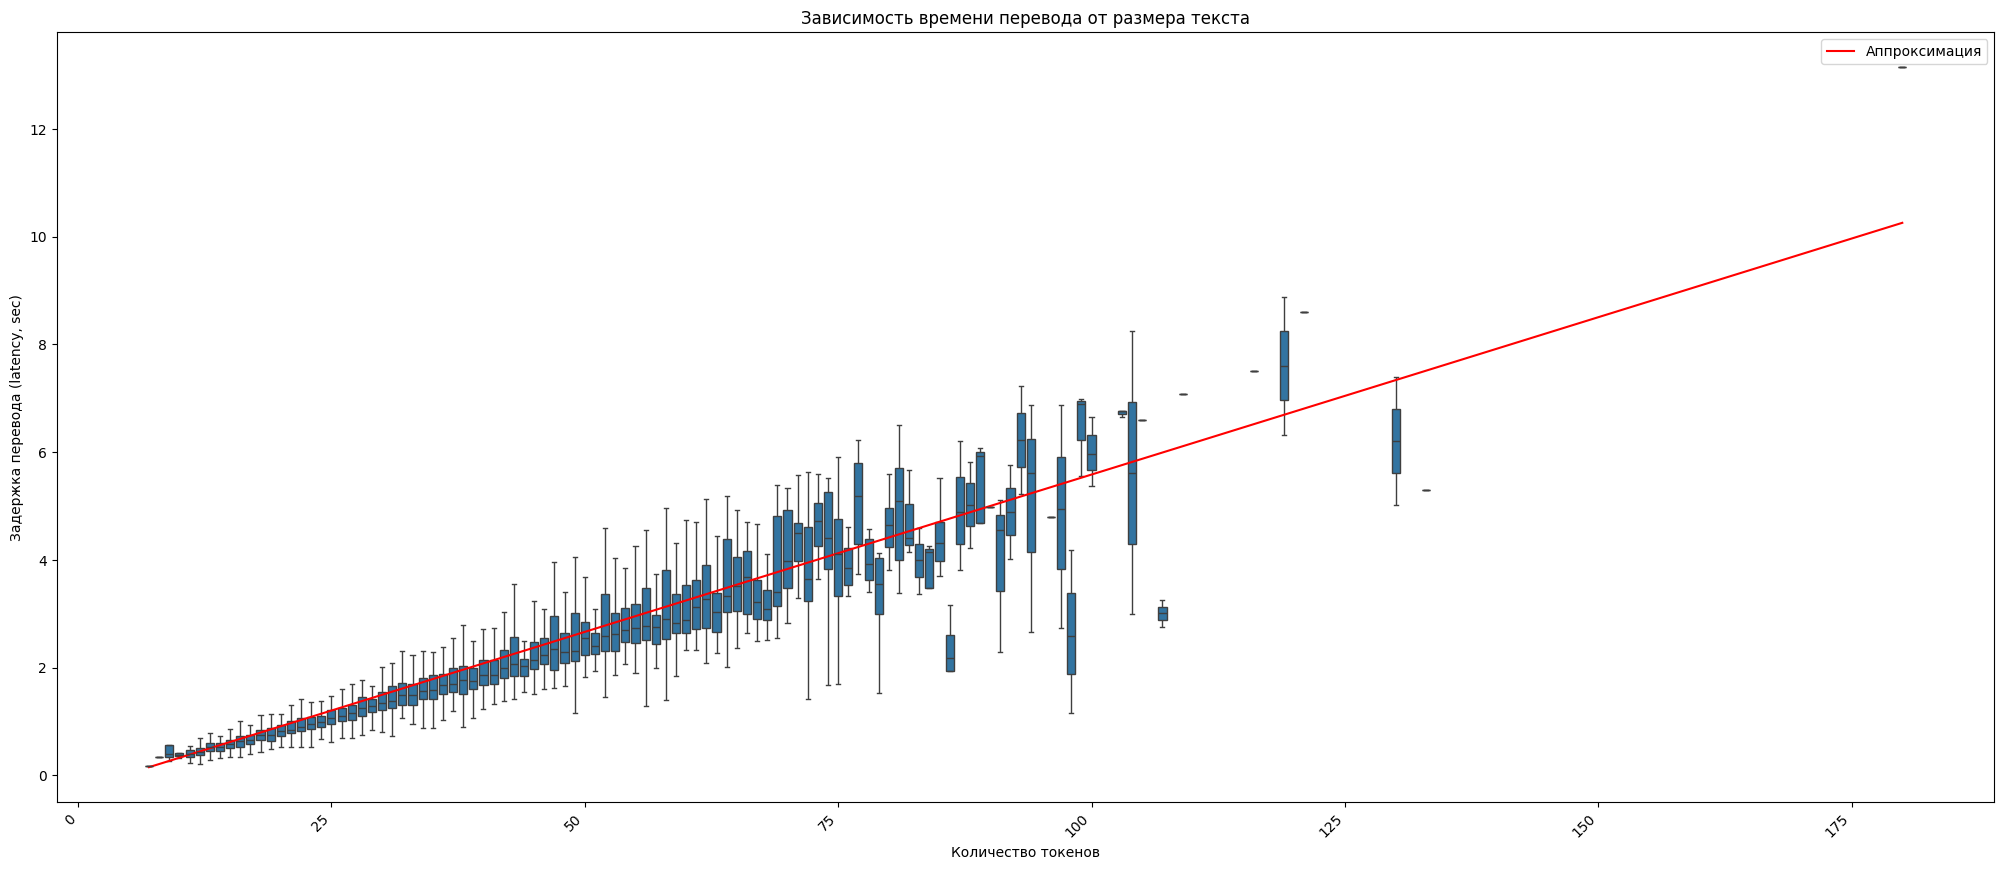

PyTorch: затрачиваемое время увеличивается, в среднем, на 0.04854 секунд за каждый новый токен, при этом модель работает не менее -0.01646 секунд.


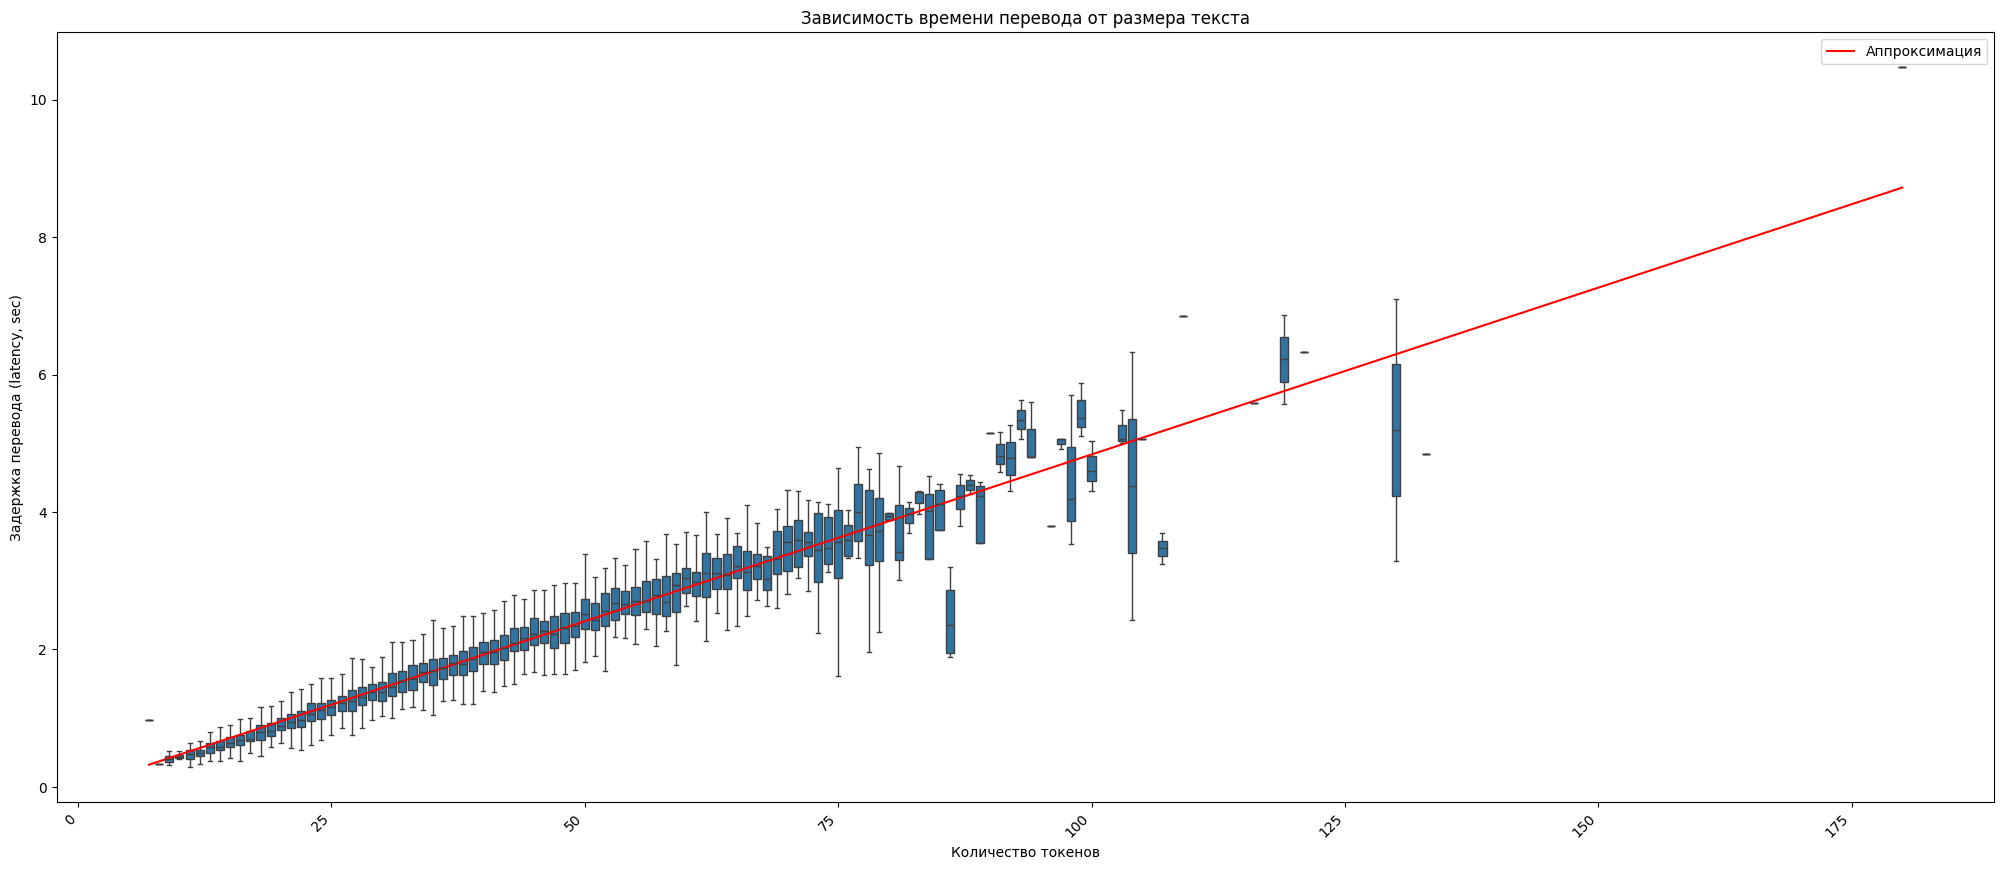

ONNX: затрачиваемое время увеличивается, в среднем, на 0.01853 секунд за каждый новый токен, при этом модель работает не менее -0.01955 секунд.


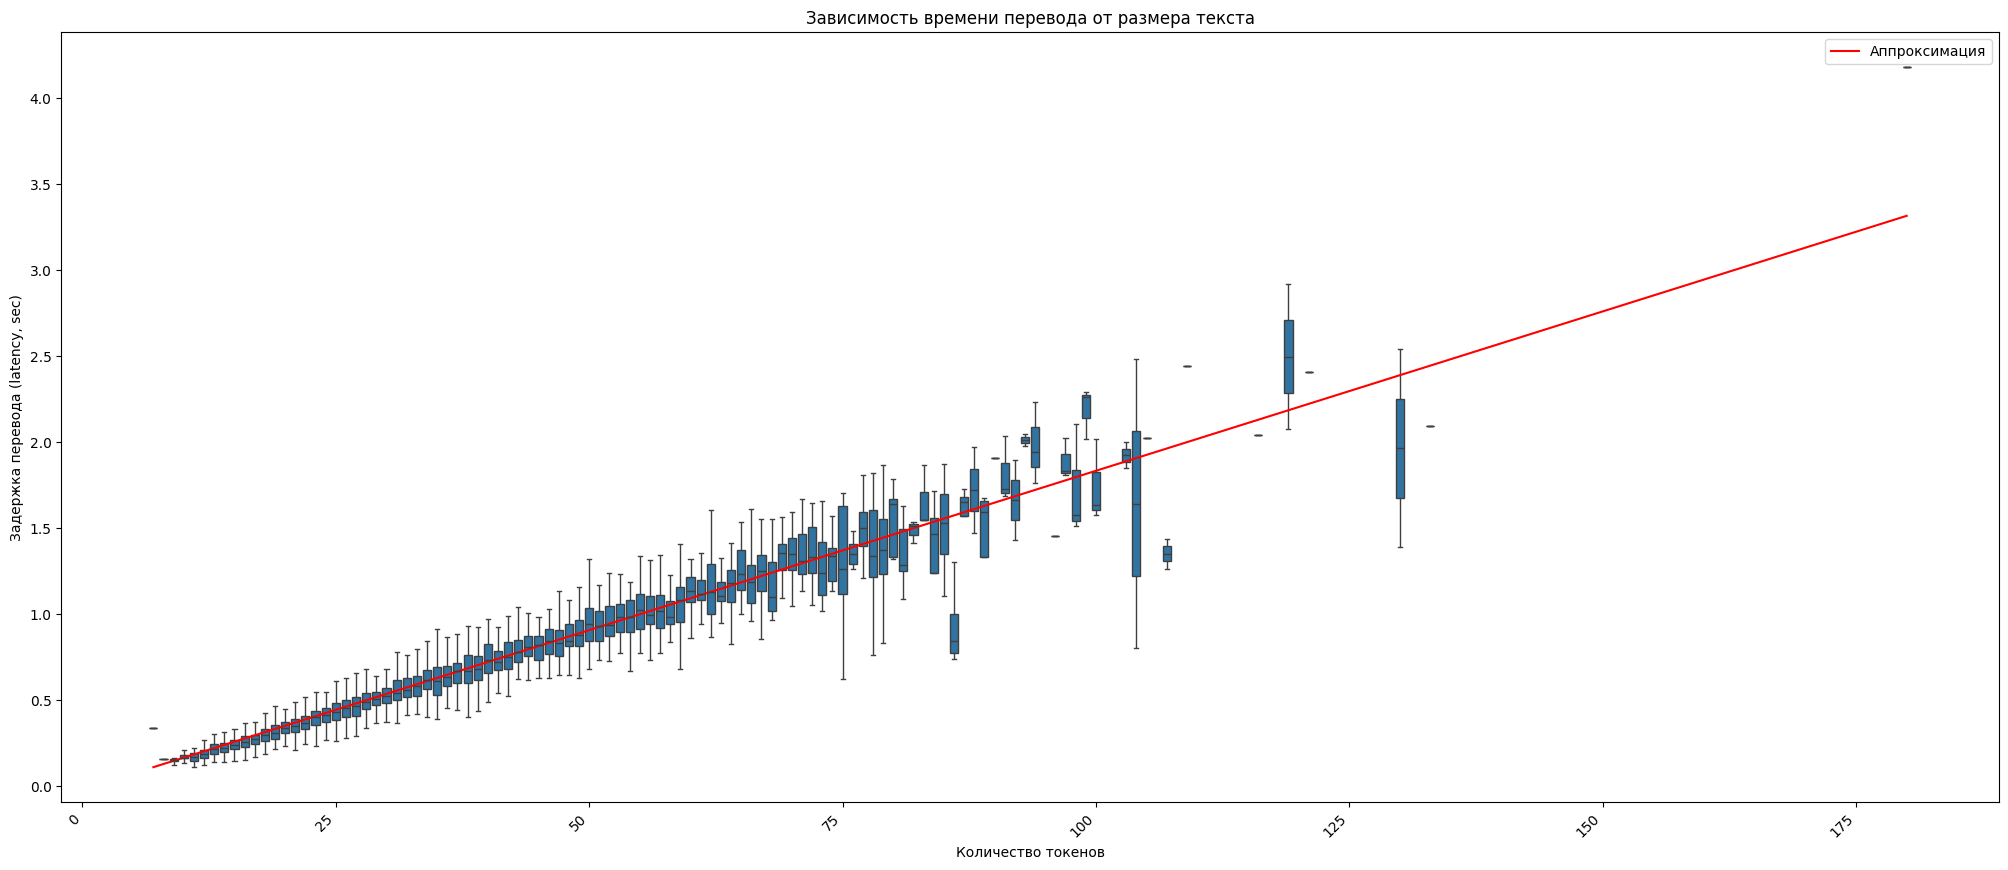

openVINO: затрачиваемое время увеличивается, в среднем, на 0.02187 секунд за каждый новый токен, при этом модель работает не менее -0.00335 секунд.


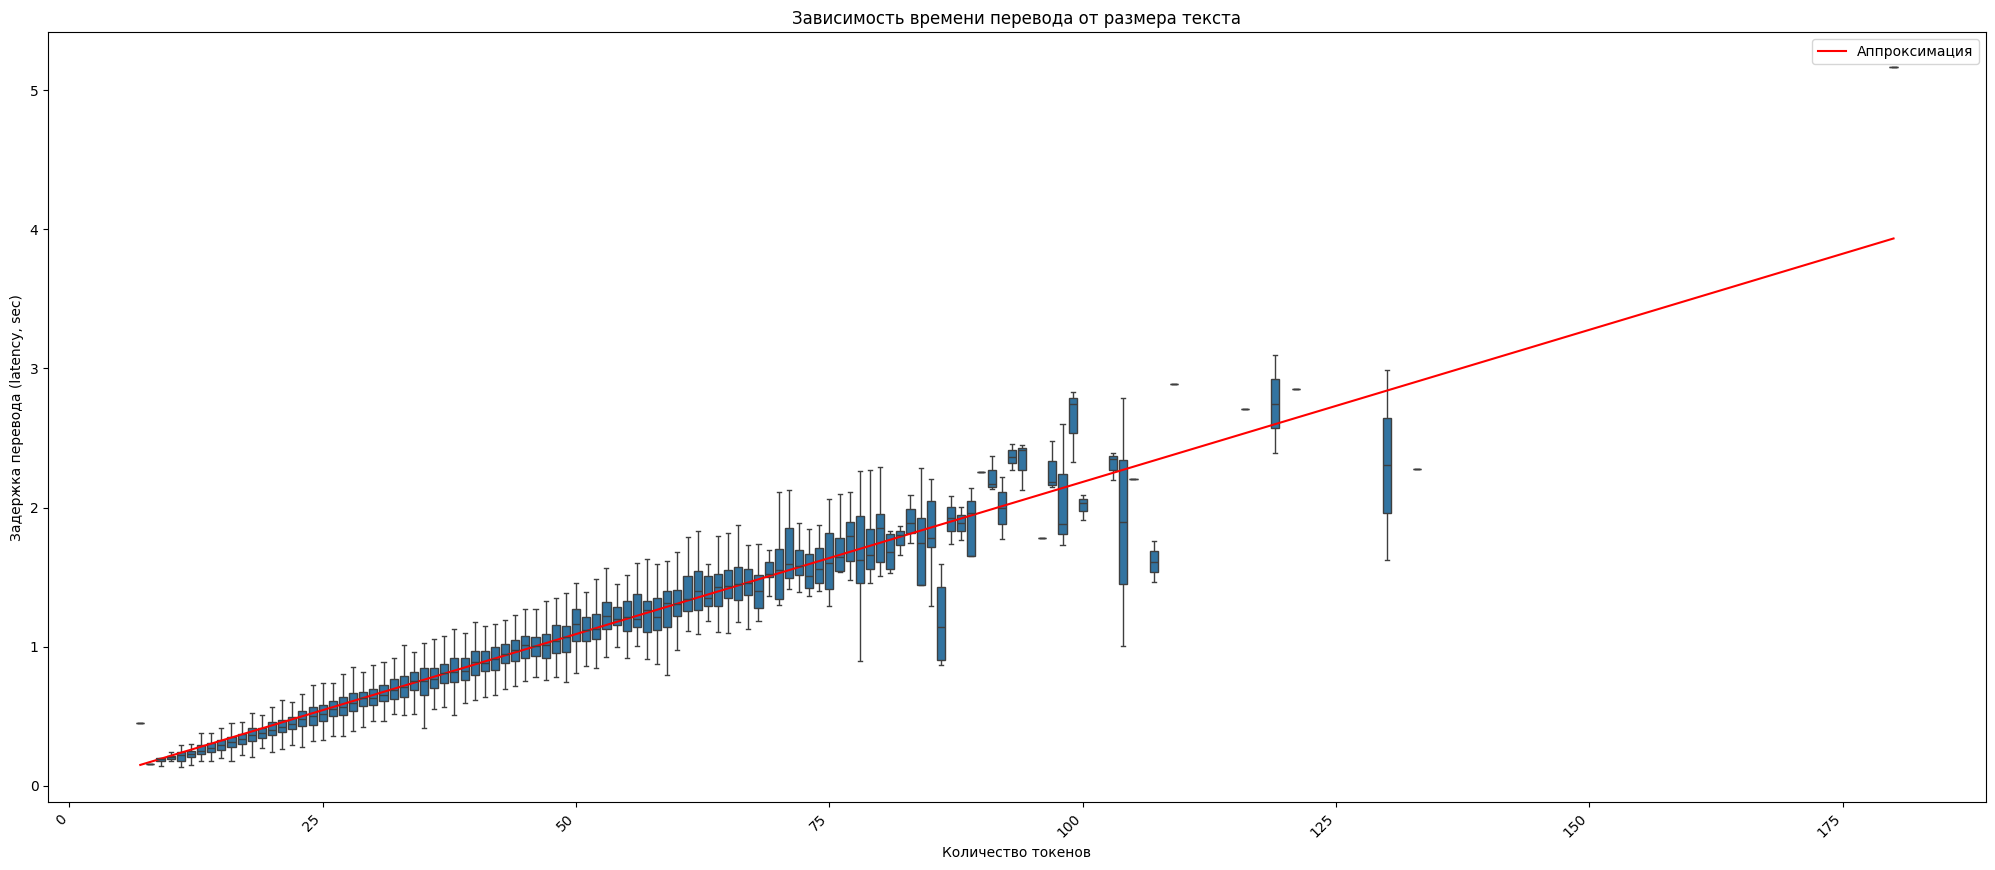

In [32]:
approximations = {}

for runtime in latency.keys():
    results = pd.DataFrame({"Tokens count": tokens_count[runtime], "Latency": latency[runtime]}) # собираем данные в DataFrame
    results.sort_values(by=["Tokens count"], inplace=True)
    results.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)

    stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                                std=("Latency", "std")
                                                                )

    outlier_indexes = []

    for index in results.index:
        tokens_count_, latency_ = results.loc[index]
        if np.abs(latency_ - stats.loc[tokens_count_]["mean"]) > 3 * stats.loc[tokens_count_]["std"]:
            outlier_indexes.append(index)

    results.drop(outlier_indexes, inplace=True)

    stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                                std=("Latency", "std")
                                                                )

    a, b = np.polyfit(stats.index[:100], stats["mean"][:100], deg=1) # считаем линейную аппроксимацию (deg=1), [:100] — так как после идёт большой разброс по времени из-за малой представленности в датасете
    approximations[runtime] = [a, b]
    print(f"{runtime}: затрачиваемое время увеличивается, в среднем, на {a:.5f} секунд за каждый новый токен, при этом модель работает не менее {b:.5f} секунд.")




    plt.figure(figsize=(25,10)) # задание размера фигуры
    sns.boxplot(x=results["Tokens count"], y=results["Latency"], native_scale=True, showfliers=False) # строим "ящики с усами", showfliers — отображать ли выбросы, native_scale — воспринимать ли ось X как непрерывную (а не категориальную)

    x = np.linspace(stats.index[0], stats.index[-1])
    # x = stats.index.to_numpy() # рассмотренные значения по оси x для линейного графика
    y = a * x + b
    sns.lineplot(x=x, y=y, color="red", label="Аппроксимация")
    # sns.pointplot(x=x, y=y, color="red", label="Аппроксимация") # pointplot в данном случае идёт как аналог линейного графика, у которого ось X воспринимается "категориально", то есть так же, как в boxplot

    plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
    plt.title("Зависимость времени перевода от размера текста") # название фигуры
    plt.xlabel("Количество токенов") # подпись по оси x
    plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
    plt.legend() # отображение подписей графиков
    plt.savefig(f"{RESULTS_DIR}runtimes/latency_{runtime}.png", dpi="figure", bbox_inches="tight", facecolor="white") # сохранение графика
    plt.show() # показ фигуры

In [33]:
colors = {
    "PyTorch": "blue",
    "ExecuTorch": "red",
    "ONNX": "green",
    "openVINO": "orange",
}

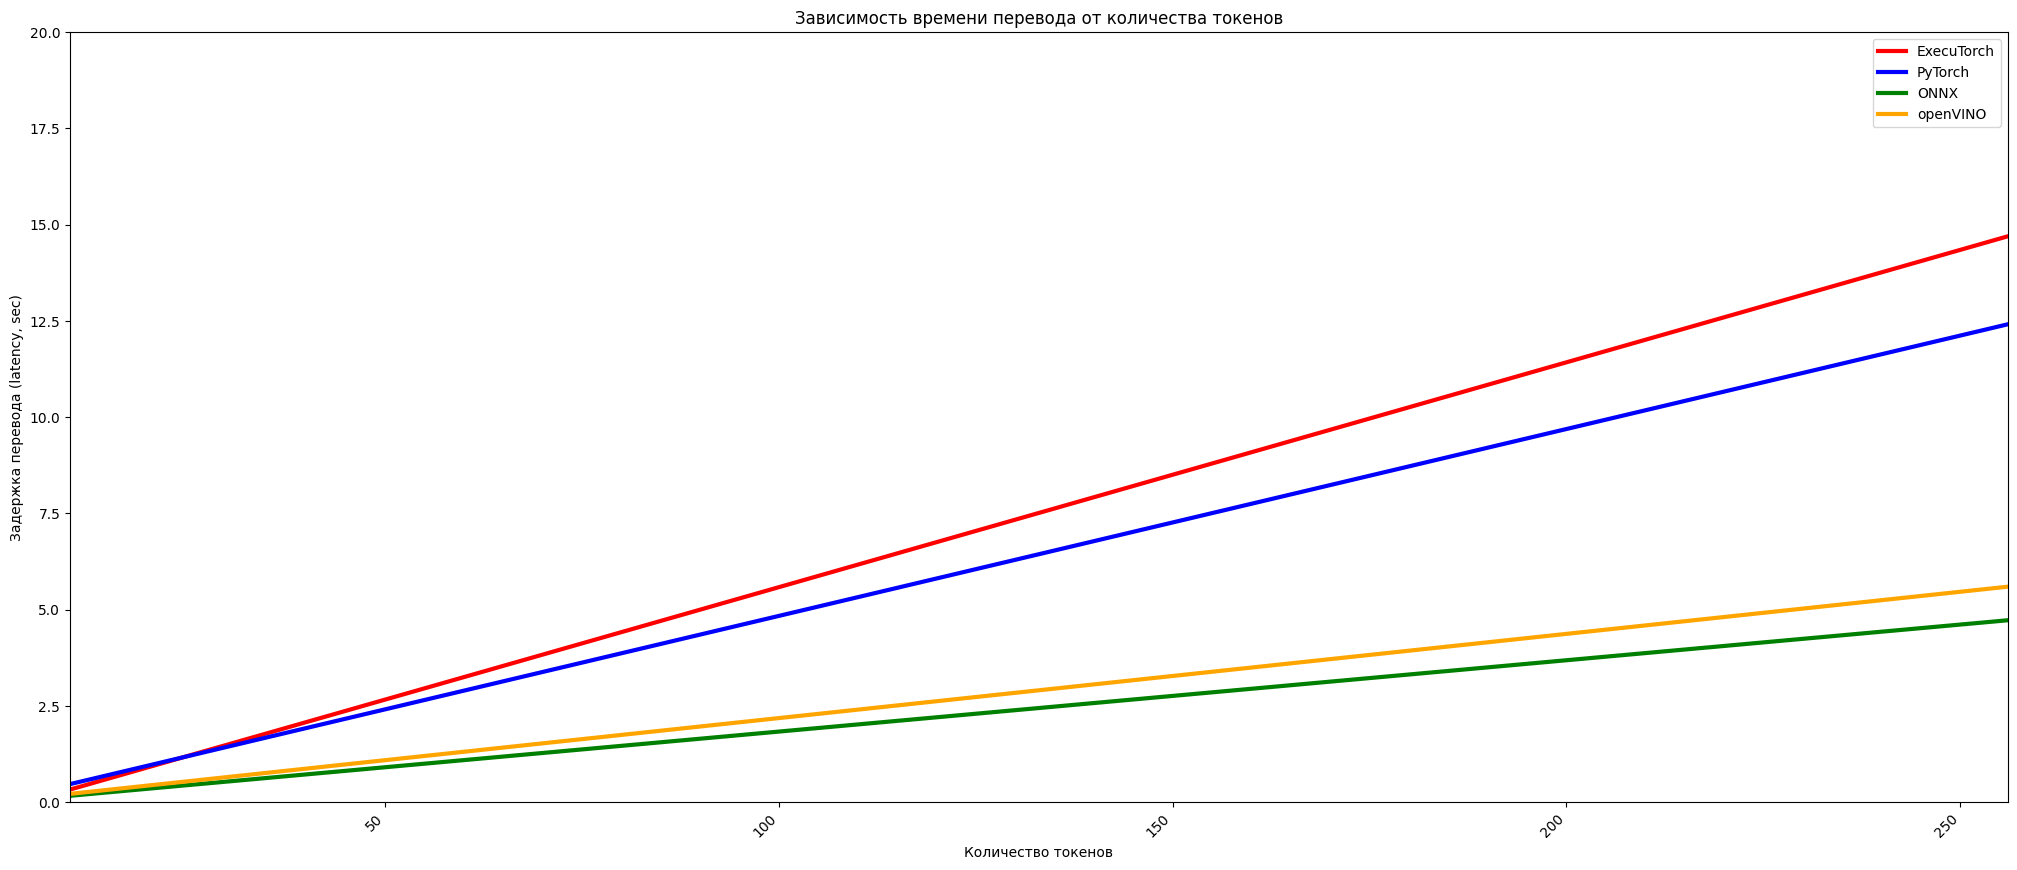

In [34]:
plt.figure(figsize=(25,10)) # задание размера фигуры

x = np.linspace(1, 256)

for runtime in approximations.keys():
    a, b = approximations[runtime]
    y = a * x + b
    sns.lineplot(x=x, y=y, label=runtime, color=colors[runtime], linewidth=3.0)

plt.axis([10, 256, 0, 20])
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Зависимость времени перевода от количества токенов") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.savefig(f"{RESULTS_DIR}runtimes/latency_comparison.png", dpi="figure", bbox_inches="tight", transparent=False, facecolor="white") # сохранение графика
plt.show() # показ фигуры

# BLEU check

In [25]:
metric_BLEU = evaluate.load("bleu") # загружаем метрику

def compute_metrics(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels] # создаём список возможных переводов

    metric = metric_BLEU.compute(predictions=preds, references=labels)["bleu"]
    return metric

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [26]:
for runtime in translations.keys():
    bleu = compute_metrics(translations[runtime], dataset["test"]["tgt"])
    with open(RESULTS_DIR + f"runtimes/bleu_{runtime}.json", mode='w', encoding='utf-8') as f: # открываем файл для записи (w — не побитовой)
        json.dump(bleu, f, ensure_ascii=False, indent=4) # сохраняем объект в файл f
    print(f"BLEU для рантайма {runtime}: {bleu:.5f}")

BLEU для рантайма ExecuTorch: 0.27302
BLEU для рантайма PyTorch: 0.27558
BLEU для рантайма ONNX: 0.27558
BLEU для рантайма openVINO: 0.27566
